In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import sys
import re

import numpy as np
import pandas as pd

import json

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
data = pd.read_csv("/content/drive/MyDrive/Project/[SJU]창의학기제/lecture_evaluation_2021/data/review_not_dup-4-token.csv")

In [6]:
data=data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

In [7]:
data.head()

,like,semester,professor_name,rate,index,lecture_name,url_id,duplicated,duplicated_id,clean_txt,aspect,cnt,1,token
0,0,20,이재교,100,0,법학입문,535020,0,-1,판례평석 잘하면 성적잘 주시는것 같음,학점,1,1.0,판례 평석 잘 면 성적 잘 시
1,1,20,오혜미,60,3,창업의이론과실제,2022697,0,-1,강의내용자체는 좋았어요 다만 원격강의로 진행되서 여러모로 불편한점이 많았습니다 출석...,수업,1,1.0,강의 내용 자체 좋 았 어요 다만 원격 강의 로 진행 서 여러모로 불편 점 많 았 ...
2,1,20,오혜미,20,4,창업의이론과실제,2022697,0,-1,강의 제목과 다르게 창업에 관한걸 배우는 것이 아니라 경영학 이론만 주구장창 암기시킴,수업,1,-1.0,강의 제목 과 다르 게 창업 관한 걸 배우 라 경영학 이론 만 주구장창 암기 시킴
3,0,19,오혜미,100,5,창업의이론과실제,2022697,0,-1,교수님 매우 착하시고 이쁘심 사랑해요 짱짱,교수,1,1.0,교수 님 매우 착하 시 이쁘 사랑 해요 짱짱
4,0,20,이유진,20,0,서양고전강독3,2100196,0,-1,1학점도 아까운 지옥의 강좌,학점,1,-1.0,학점 도 아까운 지옥 의 강좌


In [8]:
print("data 결측값 개수 :",data["1"].isnull().sum())
print("data개수:",len(data))
data_=data.dropna()
print("data 처리 후 개수:",len(data_))

data 결측값 개수 : 2468
data개수: 6998
data 처리 후 개수: 4530


In [9]:
data = data[["1","token","aspect","professor_name","lecture_name"]]

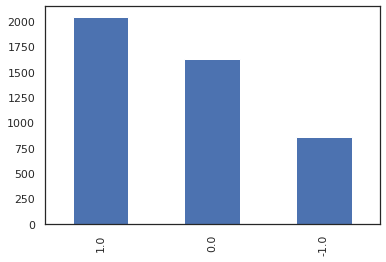

In [10]:
#label 분포 확인
data["1"].value_counts().plot(kind='bar')

In [11]:
print(data.groupby('1').size().reset_index(name='count'))

     1  count
0 -1.0    858
1  0.0   1627
2  1.0   2045


데이터 불균형으로 0의 데이터를 복제해서 비슷한 개수로 맞추어 사용!

In [12]:
df1 = data[data["1"]==0].sample(n=858)
df2 = data[data["1"]==1].sample(n=858)
df3 = data[data["1"]==-1]
df = pd.concat([df1,df2,df3], ignore_index = True)

In [13]:
len(df)

2574

In [14]:
#오버샘플링 : 복제
#duplicate_neg = data[data["1"]==0]
#data=data.append(duplicate_neg,ignore_index=True)
#print(data.groupby('1').size().reset_index(name='count'))

In [15]:
train_size = 4530
train_data = data[:train_size]
train_data.tail()

,1,token,aspect,professor_name,lecture_name
4525,1.0,좋 수업 만 잘 들으면 댐,수업,김주명,일변수미적분학
4526,1.0,잘 가르치 시 학점 후 게 십니다,학점,유호석,일변수미적분학
4527,0.0,그러나 다 어려워 해서인지 학점 잘 받 았,학점,강원,재무관리
4528,1.0,배워가 게 많 수업,수업,심동석,관리회계
4529,1.0,비대 면 기준 수업 체계 잘 잡혀,수업,유호석,일변수미적분학


In [16]:
test_data = data[train_size:]
len(test_data)

2468

In [17]:
#training, test dataset
#train_data, test_data = train_test_split(data,test_size=0.25,random_state=42)
#print('훈련용 리뷰의 개수:',len(train_data))
#print('테스트용 리뷰의 개수:',len(test_data))

In [36]:
test_data = pd.read_csv("/content/drive/MyDrive/Project/[SJU]창의학기제/lecture_evaluation_2021/data/testset_token.csv")

In [38]:
test_data.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,like,semester,professor_name,rate,index,lecture_name,url_id,duplicated,duplicated_id,clean_txt,aspect,cnt,label,token
0,0,0,1.0,0.0,20.0,이재교,100,0,법학입문,535020,1,0,중간 개망치고 기말도 틀린 문제 몇 개 있었는데 판례평석 과제 평가는 전부 A+이었음,과제,1,NaN,중간 개 망치 기말 도 틀린 문제 몇 개 는데 판례 평석 과제 평가 전부
1,1,1,1.0,0.0,20.0,이재교,100,0,법학입문,535020,1,0,중간 개망치고 기말도 틀린 문제 몇 개 있었는데 판례평석 과제 평가는 전부 A+이었음,시험,2,NaN,중간 개 망치 기말 도 틀린 문제 몇 개 는데 판례 평석 과제 평가 전부
2,2,2,3.0,0.0,20.0,이재교,80,1,법학입문,535020,1,1,시험은 말빨 좋으면 된다 난 시험은 망쳤지만 과제는 열심히해서 점수 잘 받았음,시험,2,NaN,시험 빨 좋 으면 된다 난 시험 망쳤 지만 과제 열심히 해서 점수 잘 받 았
3,3,3,3.0,0.0,20.0,이재교,80,1,법학입문,535020,1,1,과제들 되게 귀찮고 많다,과제,1,NaN,과제 되게 귀찮 많 다
4,4,4,5.0,0.0,20.0,이재교,80,2,법학입문,535020,1,2,수업만 잘 들으면 시험도 잘 볼 수 있고 성적도 후하게 주시는 편,시험,1,NaN,수업 만 잘 들으면 시험 도 잘 볼 성적 도 후하 게 시 편


In [39]:
X_train = list(train_data['token'])
y_train = pd.get_dummies(train_data['1']).values
X_test = list(test_data['token'])

In [ ]:
X_train[1000:1100]

In [40]:
sentence_length = [len(str(l).split()) for l in data["token"]]
np.array(sentence_length).mean()

12.158616747642183

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


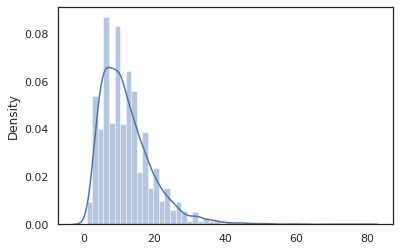

In [21]:
sns.distplot(sentence_length) #padding = 20

In [22]:
max_len = 20

In [41]:
#단어집합 만들기
t = Tokenizer()
t.fit_on_texts(data["token"])
vocab_size = len(t.word_index) + 1

print(vocab_size)
#["문장1","문장2",...,"문장n"] 리스트 형태로 들어가면 띄어쓰기로 split되고 단어집합을 만듦
word_index = t.word_index
dict(list(word_index.items())[10:40])

5848


{'거': 18,
 '기': 16,
 '내용': 40,
 '너무': 36,
 '는데': 14,
 '듣': 33,
 '라': 34,
 '로': 24,
 '만': 15,
 '많': 23,
 '많이': 38,
 '문제': 29,
 '받': 30,
 '번': 28,
 '생각': 37,
 '시험': 12,
 '안': 19,
 '았': 26,
 '어': 31,
 '으로': 20,
 '의': 27,
 '잘': 11,
 '적': 25,
 '점수': 39,
 '좋': 13,
 '지만': 22,
 '학점': 21,
 '할': 35,
 '해': 17,
 '했': 32}

In [42]:
train_sequences = t.texts_to_sequences(X_train) #정수인코딩\
test_sequences = t.texts_to_sequences(X_test) 
print(train_sequences[10])
print(test_sequences[10])

[670, 585, 2, 126, 120, 25, 20, 351, 97, 41, 2, 34, 37, 318]
[12, 29, 1, 141, 26, 410]


In [43]:
train_padded = pad_sequences(train_sequences, maxlen=max_len) #padding
test_padded = pad_sequences(test_sequences, maxlen=max_len)
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(test_sequences[1]))
print(len(test_padded[1]))

7
20
14
20


# LSTM 모델 학습

In [44]:
import tensorflow as tf
model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(vocab_size, 32, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(8, activation='relu'),
    # Add a Dense layer with 3 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(3, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 32)            187136    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                16640     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 27        
Total params: 204,323
Trainable params: 204,323
Non-trainable params: 0
_________________________________________________________________


In [45]:
#모델 컴파일하고 훈련
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_padded, y_train, 
                    epochs=10, 
                    verbose=2, 
                    batch_size=128,
                    validation_split = 0.2)

Epoch 1/10
29/29 - 4s - loss: 1.0634 - accuracy: 0.4619 - val_loss: 1.0504 - val_accuracy: 0.3985
Epoch 2/10
29/29 - 1s - loss: 0.9594 - accuracy: 0.5210 - val_loss: 0.8773 - val_accuracy: 0.6623
Epoch 3/10
29/29 - 1s - loss: 0.7795 - accuracy: 0.6562 - val_loss: 0.8246 - val_accuracy: 0.6843
Epoch 4/10
29/29 - 1s - loss: 0.6604 - accuracy: 0.7020 - val_loss: 0.8818 - val_accuracy: 0.6777
Epoch 5/10
29/29 - 1s - loss: 0.5922 - accuracy: 0.7310 - val_loss: 0.9242 - val_accuracy: 0.6799
Epoch 6/10
29/29 - 1s - loss: 0.5338 - accuracy: 0.7492 - val_loss: 0.9457 - val_accuracy: 0.6755
Epoch 7/10
29/29 - 1s - loss: 0.4912 - accuracy: 0.7613 - val_loss: 1.0098 - val_accuracy: 0.6567
Epoch 8/10
29/29 - 1s - loss: 0.4532 - accuracy: 0.7906 - val_loss: 1.0673 - val_accuracy: 0.6534
Epoch 9/10
29/29 - 1s - loss: 0.4161 - accuracy: 0.8223 - val_loss: 1.2901 - val_accuracy: 0.6026
Epoch 10/10
29/29 - 1s - loss: 0.3933 - accuracy: 0.8336 - val_loss: 1.2057 - val_accuracy: 0.6148


In [46]:
predictions_single = model.predict(test_padded)

print(predictions_single)

[[4.8041621e-01 2.9364666e-01 2.2593711e-01]
 [4.8041621e-01 2.9364666e-01 2.2593711e-01]
 [2.7086979e-03 2.9899860e-02 9.6739143e-01]
 ...
 [3.1541320e-03 2.9721644e-03 9.9387372e-01]
 [1.8018991e-03 9.9743867e-01 7.5944362e-04]
 [1.8018991e-03 9.9743867e-01 7.5944362e-04]]


In [47]:
from sklearn.metrics import classification_report
y_predicted = model.predict(test_padded)
y_predicted = y_predicted.argmax(axis=-1) # 예측된 정수 시퀀스로 변환
y_predicted

array([0, 0, 2, ..., 2, 1, 1])

In [55]:
test_data["score"]=y_predicted-1
test_data.tail(20)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,like,semester,professor_name,rate,index,lecture_name,url_id,duplicated,duplicated_id,clean_txt,aspect,cnt,label,token,predict
9904,9904,4924,10979.0,0.0,20.0,황용식,100,10,취업과진로,2183783,1,4299,패논패에 중간 기말 모두 과제 대체여서 부담없이 듣기 좋음취업에 관련된 기본적인 것...,과제,1,1,패 논 패 중간 기말 모두 과제 대체 여서 부담없이 듣 기 좋 취업 관련 된 기본 ...,1
9905,9905,4925,10979.0,0.0,20.0,황용식,100,10,취업과진로,2183783,1,4299,패논패에 중간 기말 모두 과제 대체여서 부담없이 듣기 좋음취업에 관련된 기본적인 것...,시험,2,1,패 논 패 중간 기말 모두 과제 대체 여서 부담없이 듣 기 좋 취업 관련 된 기본 ...,1
9906,9906,4926,10981.0,0.0,20.0,황용식,100,11,취업과진로,2183783,1,4300,중간 기말 과제도 강의 듣고 소감 조금 쓰는 거 그런 거밖에 없고,시험,2,0,중간 기말 과제 도 강의 듣 소감 조금 쓰 거 그런 거 밖에,0
9907,9907,4927,10981.0,0.0,20.0,황용식,100,11,취업과진로,2183783,1,4300,중간 기말 과제도 강의 듣고 소감 조금 쓰는 거 그런 거밖에 없고,수업,3,0,중간 기말 과제 도 강의 듣 소감 조금 쓰 거 그런 거 밖에,0
9908,9908,4928,10981.0,0.0,20.0,황용식,100,11,취업과진로,2183783,1,4300,중간 기말 과제도 강의 듣고 소감 조금 쓰는 거 그런 거밖에 없고,과제,1,0,중간 기말 과제 도 강의 듣 소감 조금 쓰 거 그런 거 밖에,0
9909,9909,4929,10982.0,0.0,20.0,황용식,100,12,취업과진로,2183783,1,4301,크게 힘 안 들이고 2학점 챙길 수 있는 강의,학점,1,1,크 게 힘 안 들이 학점 챙길 강의,1
9910,9910,4930,10982.0,0.0,20.0,황용식,100,12,취업과진로,2183783,1,4301,크게 힘 안 들이고 2학점 챙길 수 있는 강의,수업,2,1,크 게 힘 안 들이 학점 챙길 강의,1
9911,9911,4931,11976.0,1.0,20.0,황용식,100,0,취업전략및사회진출,2183788,1,4302,"강의는 취업하시려는 분들께 도움 되는데, 과제는 중간고사 기말고사 대체과제로 두개밖...",과제,1,0,강의 취업 시 려는 분 께 도움 데 과제 중간고사 기말고사 대체 과제 로 두 개 밖...,0
9912,9912,4932,11976.0,1.0,20.0,황용식,100,0,취업전략및사회진출,2183788,1,4302,"강의는 취업하시려는 분들께 도움 되는데, 과제는 중간고사 기말고사 대체과제로 두개밖...",시험,2,0,강의 취업 시 려는 분 께 도움 데 과제 중간고사 기말고사 대체 과제 로 두 개 밖...,0
9913,9913,4933,11976.0,1.0,20.0,황용식,100,0,취업전략및사회진출,2183788,1,4302,"강의는 취업하시려는 분들께 도움 되는데, 과제는 중간고사 기말고사 대체과제로 두개밖...",수업,3,0,강의 취업 시 려는 분 께 도움 데 과제 중간고사 기말고사 대체 과제 로 두 개 밖...,0


In [56]:
test_data.to_csv('/content/drive/MyDrive/Project/[SJU]창의학기제/lecture_evaluation_2021/data/testset_predict.csv')

In [52]:
data_file = test_data.groupby(['professor_name','lecture_name','aspect']).mean()

In [57]:
data_file.to_csv('/content/drive/MyDrive/Project/[SJU]창의학기제/lecture_evaluation_2021/data/testset_groupby.csv')

In [54]:
data_file.head()

Unnamed: 0  ...  predict
professor_name             lecture_name aspect              ...         
Abolghasem Sadeghi-Niaraki 소프트웨어특강1     과제          8301.8  ...      0.4
                                        교수          8301.6  ...      0.4
                                        수업          8303.0  ...      0.4
                                        시험          8308.0  ...      0.5
                                        학점          8295.0  ...      0.5

[5 rows x 13 columns]

In [31]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

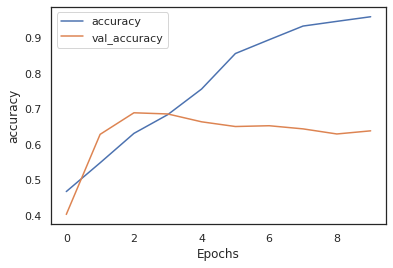

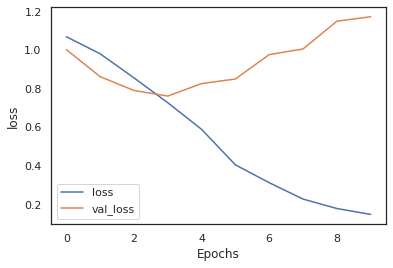

In [33]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [34]:
test_sequences = tokenizer.texts_to_sequences(X_test) #정수인코딩
test_padded = pad_sequences(test_sequences, maxlen=max_len) #padding
y_predicted = model.predict(test_padded)
y_predicted = y_predicted.argmax(axis=-1) # 예측된 정수 시퀀스로 변환
test_data["y_predicted"] = y_predicted

NameError: ignored